In [8]:
import re
import bz2
import boto3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Download and process the data from S3

In [2]:
s3_client = boto3.client('s3')

s3_client.download_file(
    Bucket='mlops-zc-ta-dev-dataset', 
    Key='raw/train.ft.txt.bz2.zip', 
    Filename='../data/raw/train.ft.txt.bz2.zip'
)

s3_client.download_file(
    Bucket='mlops-zc-ta-dev-dataset', 
    Key='raw/test.ft.txt.bz2.zip', 
    Filename='../data/raw/test.ft.txt.bz2.zip'
)

In [4]:
train = bz2.BZ2File('../data/raw/train.ft.txt.bz2')
test = bz2.BZ2File('../data/raw/test.ft.txt.bz2')

In [6]:
# Read in the data
train = train.readlines()
test = test.readlines()

In [8]:
# Byte to unicode
train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]

In [28]:
# Preprocess the data to extract the label and the text
def prepare_data(data):
    label = list()
    text_list = list()
    for text in data:
        tmp = tmp = re.search(r'(__label__\d+)', text)
        if tmp.group(0) == '__label__1':
            label.append(0)
        else:
            label.append(1)
        
        tmp = re.sub(r'__label__\d+ ', '', text)
        tmp = re.sub(r'\n', '', tmp)
        text_list.append(tmp)
    return text_list, label

In [32]:
# Apply the prepare_data function to the train and test dataframes
train_texts, train_labels = prepare_data(train)
test_texts, test_labels = prepare_data(test)

In [35]:
# Convert the data into a pandas dataframe
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}, columns=['text', 'label'])

test_df = pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}, columns=['text', 'label'])

In [36]:
# Create a new column that maps the label to a string
train_df['label_name'] = train_df['label'].apply(lambda x: 'positive' if x == 1 else 'negative')
test_df['label_name'] = test_df['label'].apply(lambda x: 'positive' if x == 1 else 'negative')

In [37]:
# Save the dataframes as parquet files
train_df.to_parquet('../data/raw/train.parquet')
test_df.to_parquet('../data/raw/test.parquet')

## Read the raw data

In [35]:
# Read in the data
train_df = pd.read_parquet('../data/raw/train.parquet')
test_df = pd.read_parquet('../data/raw/test.parquet')

## Exploratory Data Analysis

Let's explore the data a bit.

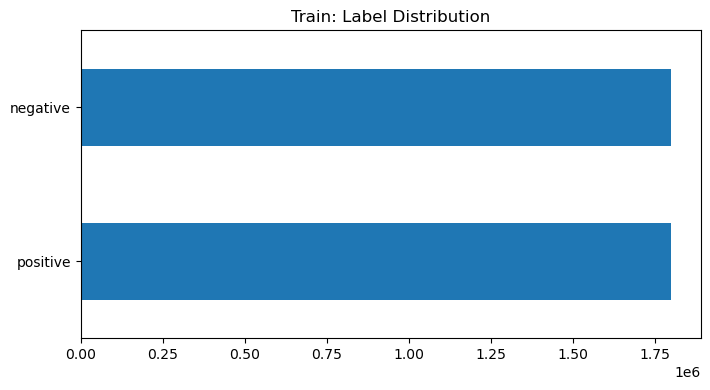

In [14]:
# Display the distribution of labels in the training data
train_df.label_name.value_counts().plot(kind='barh', figsize=(8,4), title='Train: Label Distribution');
plt.show()

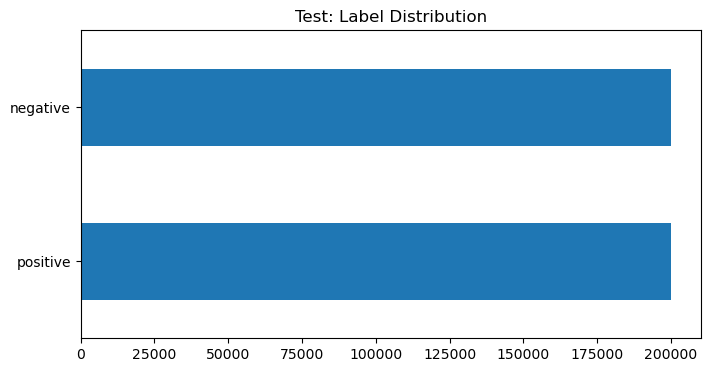

In [15]:
# Display the distribution of labels in the testing data
test_df.label_name.value_counts().plot(kind='barh', figsize=(8,4), title='Test: Label Distribution')
plt.show()

In [17]:
train_df['words_per_review'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['words_per_review'] = test_df['text'].apply(lambda x: len(x.split()))

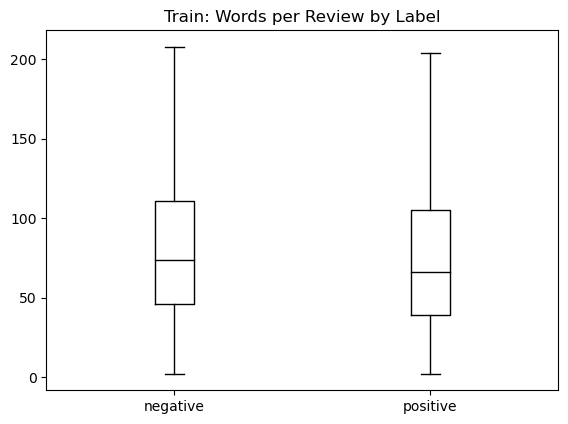

In [23]:
train_df.boxplot("words_per_review", by="label_name", grid=False, showfliers=False, color="black")
plt.title("Train: Words per Review by Label")
plt.suptitle("")
plt.xlabel("")
plt.show()

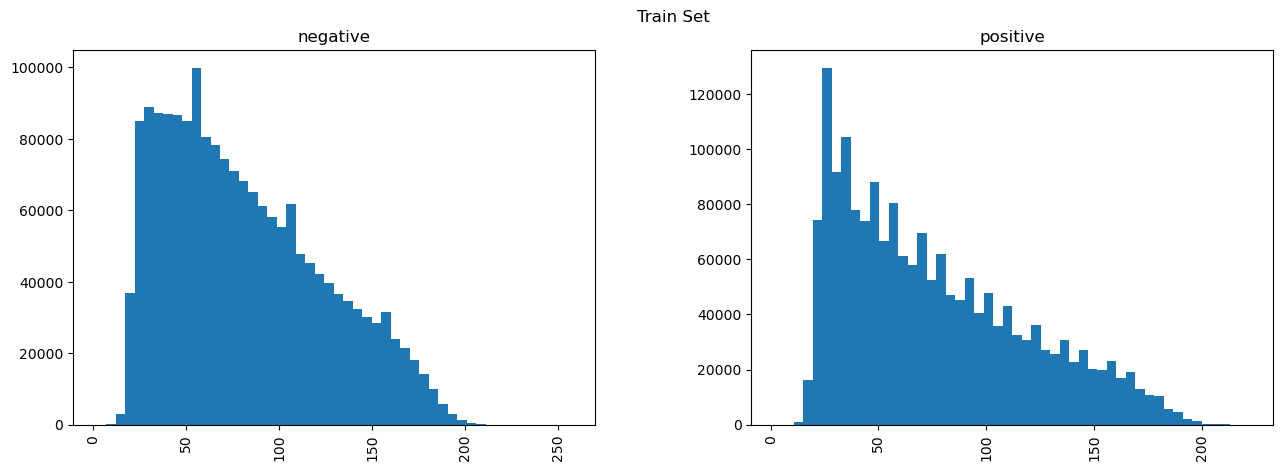

In [33]:
train_df.hist('words_per_review', by='label_name', figsize=(15,5), bins=50)
plt.suptitle('Train Set')
plt.show()

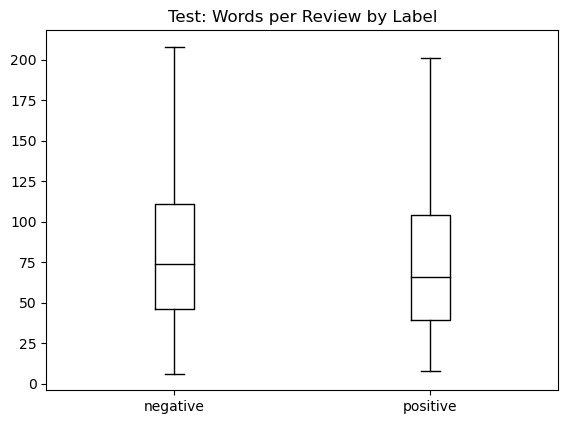

In [22]:
test_df.boxplot("words_per_review", by="label_name", grid=False, showfliers=False, color="black")
plt.title("Test: Words per Review by Label")
plt.suptitle("")
plt.xlabel("")
plt.show()

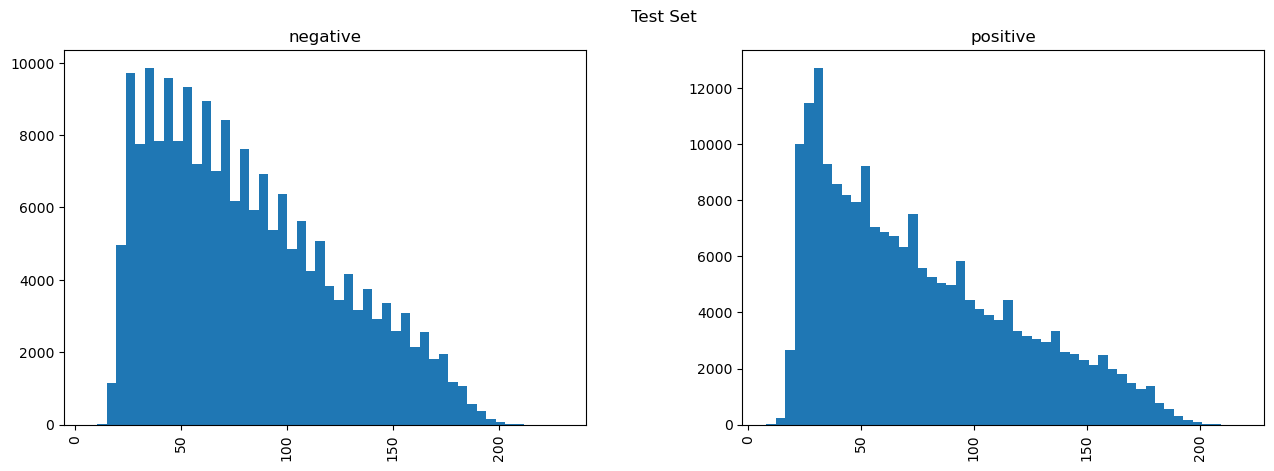

In [32]:
test_df.hist('words_per_review', by='label_name', figsize=(15,5), bins=50)
plt.suptitle('Test Set')
plt.show()